In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -a 'Marcos Santana' -d -p fastai,numpy,pandas,torch,joblib,guacamol,fastinference,rdkit,tqdm -v

Author: Marcos Santana

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

fastai       : 2.5.2
numpy        : 1.20.1
pandas       : 1.2.4
torch        : 1.9.0
joblib       : 1.0.1
guacamol     : 0.5.2
fastinference: 0.0.36
rdkit        : 2021.03.5
tqdm         : 4.59.0



In [204]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from fastai.text.all import *

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [116]:
learn = load_learner('/home/marcossantana/Downloads/export.pkl', cpu=False)

In [4]:
spec_tokens = "xxunk xxpad xxbos xxeos xxfld xxrep xxwrep xxup xxmaj xxfake".split()

In [5]:
acceptable_chars = []
for i in learn.dls.vocab:
    if i not in spec_tokens:
        if i.isalpha() or i.startswith('['):
            acceptable_chars.append(i)


In [168]:
def base_sampler(model, seed='', max_size=20, temperature=1.0):
    '''Base sampler to generate one SMILES using a chemistry model trained with fastai
    temperature : sampling temperature (default = 0.7)
    max_size : maximum size of the SMILES strings (default = 100)'''
    
    act = getattr(model.loss_func, 'activation', noop)
    model.model.cuda()
    
    # Reset the model
    model.model.reset()    
    
    # Define stop and start tokens
    stop_token = model.dls.train.vocab.index(BOS)
    start_token = model.dls.test_dl([seed]).items[0].to(model.dls.device)
    
    
    # Numericalize (used to decode)
    nums = model.dls.train_ds.numericalize   
    
    molecule = []                   # Store predicted tokens
    model.model.eval()

    for _ in range(max_size):
        with torch.no_grad(): preds = model.model(start_token[None])[0][-1]
        
        res = act(preds)
        if temperature != 1.: res.pow_(1 / temperature)
        idx = torch.multinomial(res, 1).item()           
        
        if idx != stop_token:
            molecule.append(idx)
            start_token = start_token.new_tensor([idx])
            
            
        else:
            break
    molecule = ''.join([nums.vocab[o] for o in molecule if nums.vocab[o] not in [BOS, PAD]])  # Decode predicted tokens
    return molecule

In [163]:
seed=''
#Chem.MolFromSmiles(text)

In [166]:
prod1 = base_sampler(learn,seed='',max_size=20)

In [167]:
prod1

'CNC(=O)[C@@H](NC(=O)[C@H](CCC'

In [84]:
for _ in range(20):
    prod1 = base_sampler(learn,text='',max_size=20)
    prod2 = base_sampler_seeds(learn,text='',max_size=20)
    
    print(prod1, prod2)

CC#Cc1cncc(-c2cccc([C@] N=C(N)NCCC[C@@H]1NC(=O)[C@H]2
CC1(C)Oc2ccc(NC(=O)c O=C(O)[C@@H]1[C@@H](S(=O)(=O)C
Cc1ccc(-c2c3ccccc3c( Cc1ccc(S(=O)(=O)N2CC
COc1ccc(-c2cc(N3C[C@H](c NCC(=O)Nc1ccc(OP(=O)
COCCCOc1cc(C[C@@H](C[C@H](N)[C@@H] Cc1cnc(C(CC(=O)O)c2c
COc1ccc(S(=O)(=O)[C@@H](C CCC(CC)(Cc1ccc(C(=O)
CC(C)=CCC/C(C)=C/Cc1 O=C(NC1CCN(C(=O)c2cc
C/C(=C(\F)C(=O)Nc1cc Cc1cc2oc(Oc3ccc4c(c3
COc1cccc(C(=O)N[C@@H](CC( CN(Cc1cn(CC(C)(C)C)n
Cc1cc2cc(N/C(=N\S(=O CN(C)Cc1ccccc1-c1ccc
CCCN(CCC)C(=O)c1cc(C CC(C)c1cc(C(C)C)c(S(
COc1ccc(-c2nc3ccc(Cl) O=C1NNC(=S)S/C1=C\c1
N=C(N)c1ccc2[nH]c(-c3cc C/C(=N/[C@@H]1CCCC[C@@H]1NC(=O
Cc1cc2ccc1[C@@H](C)COC(=O CS(=O)(=O)Nc1ccc(CCN
N=C(N)NCCC[C@@H](C=O)NC(= COCCCCn1cc([C@@H](C)N(C(=
CC(=N)N1CCC(Oc2ccc3c C[C@H](NC(=O)CNC(=O)[C@@H](NS
O=C(O)[C@H](Cc1ccccc1)NS CC(C)Oc1cc(O)ccc1[C@@H]1C
CCN(CC)c1cccc2c(S(=O CN1C(=N)NC(c2cccc(-c
Cc1cc(Cl)cc(C(=O)NO)c N=C(N)c1ccc(CNC(=O)[C@@H]
CCc1nc2cccc(CCC)c2c( O=P(O)(O)C(Nc1ccc(Oc


In [81]:
prod1,prod2

('CC(C)[C@H](NC(=O)Nc1cccc', 'CCCCCOCNCCOC[C@H]OOCCOcC')

# Validation

In [234]:
from generative.DistributionBenchmark import *

In [235]:
distrib_benchmark = MolSampler(model_fname='/home/marcossantana/Downloads/export.pkl')

# Max size impact

How does validity performance changes w.r.t max_size?

In [188]:
def generate_mols(model,seed='', max_size=100, max_mols=100, temperature=1.0,**kwargs):
    '''Generate molecules using a base sampler'''
        
    return [base_sampler(model=model, seed=seed, max_size=max_size, temperature=temperature) for i in range(max_mols)]

[20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

In [256]:
sizes = {size : {'validity':[],'uniqueness':[], 'novelty':[]} for size in list(range(20, 220, 20))}
for size in sizes.keys():
    val, nov, unq = distrib_benchmark.generative_benchmark(max_size=size,max_mols=100,iterations=5,temperatures=[1.0])
    sizes[size]['validity']=val
    sizes[size]['novelty']=nov
    sizes[size]['uniqueness']=unq

Sampling with temperature 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

[0.05] [0.05] [0.05]
[0.05, 0.08] [0.05, 0.08] [0.05, 0.08]
[0.05, 0.08, 0.11] [0.05, 0.08, 0.11] [0.05, 0.08, 0.11]
[0.05, 0.08, 0.11, 0.04] [0.05, 0.08, 0.11, 0.04] [0.05, 0.08, 0.11, 0.04]
[0.05, 0.08, 0.11, 0.04, 0.07] [0.05, 0.08, 0.11, 0.04, 0.07] [0.05, 0.08, 0.11, 0.04, 0.07]
Sampling with temperature 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

[0.2] [0.2] [0.2]
[0.2, 0.17] [0.2, 0.17] [0.2, 0.17]
[0.2, 0.17, 0.13] [0.2, 0.17, 0.13] [0.2, 0.17, 0.13]
[0.2, 0.17, 0.13, 0.19] [0.2, 0.17, 0.13, 0.19] [0.2, 0.17, 0.13, 0.19]
[0.2, 0.17, 0.13, 0.19, 0.2] [0.2, 0.17, 0.13, 0.19, 0.2] [0.2, 0.17, 0.13, 0.19, 0.2]
Sampling with temperature 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

[0.68] [0.68] [0.68]
[0.68, 0.57] [0.68, 0.57] [0.68, 0.57]
[0.68, 0.57, 0.63] [0.68, 0.57, 0.63] [0.68, 0.57, 0.63]
[0.68, 0.57, 0.63, 0.71] [0.68, 0.57, 0.63, 0.71] [0.68, 0.57, 0.63, 0.71]
[0.68, 0.57, 0.63, 0.71, 0.63] [0.68, 0.57, 0.63, 0.71, 0.63] [0.68, 0.57, 0.63, 0.71, 0.63]
Sampling with temperature 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

[0.96] [0.96] [0.96]
[0.96, 0.98] [0.96, 0.98] [0.96, 0.98]
[0.96, 0.98, 0.94] [0.96, 0.98, 0.94] [0.96, 0.98, 0.94]
[0.96, 0.98, 0.94, 0.92] [0.96, 0.98, 0.94, 0.92] [0.96, 0.98, 0.94, 0.92]
[0.96, 0.98, 0.94, 0.92, 0.93] [0.96, 0.98, 0.94, 0.92, 0.93] [0.96, 0.98, 0.94, 0.92, 0.93]
Sampling with temperature 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

[0.97] [0.97] [0.97]
[0.97, 0.93] [0.97, 0.93] [0.97, 0.93]
[0.97, 0.93, 0.96] [0.97, 0.93, 0.96] [0.97, 0.93, 0.96]
[0.97, 0.93, 0.96, 0.96] [0.97, 0.93, 0.96, 0.96] [0.97, 0.93, 0.96, 0.96]
[0.97, 0.93, 0.96, 0.96, 0.98] [0.97, 0.93, 0.96, 0.96, 0.98] [0.97, 0.93, 0.96, 0.96, 0.98]
Sampling with temperature 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

[0.97] [0.97] [0.97]
[0.97, 0.96] [0.97, 0.96] [0.97, 0.96]
[0.97, 0.96, 0.94] [0.97, 0.96, 0.94] [0.97, 0.96, 0.94]
[0.97, 0.96, 0.94, 0.98] [0.97, 0.96, 0.94, 0.98] [0.97, 0.96, 0.94, 0.98]
[0.97, 0.96, 0.94, 0.98, 0.9] [0.97, 0.96, 0.94, 0.98, 0.9] [0.97, 0.96, 0.94, 0.98, 0.9]
Sampling with temperature 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

[0.95] [0.95] [0.95]
[0.95, 0.93] [0.95, 0.93] [0.95, 0.93]
[0.95, 0.93, 0.98] [0.95, 0.93, 0.98] [0.95, 0.93, 0.98]
[0.95, 0.93, 0.98, 0.95] [0.95, 0.93, 0.98, 0.95] [0.95, 0.93, 0.98, 0.95]
[0.95, 0.93, 0.98, 0.95, 0.97] [0.95, 0.93, 0.98, 0.95, 0.97] [0.95, 0.93, 0.98, 0.95, 0.97]
Sampling with temperature 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

[0.98] [0.97] [0.97]
[0.98, 0.96] [0.97, 0.96] [0.97, 0.96]
[0.98, 0.96, 0.94] [0.97, 0.96, 0.94] [0.97, 0.96, 0.94]
[0.98, 0.96, 0.94, 0.95] [0.97, 0.96, 0.94, 0.95] [0.97, 0.96, 0.94, 0.95]
[0.98, 0.96, 0.94, 0.95, 0.94] [0.97, 0.96, 0.94, 0.95, 0.93] [0.97, 0.96, 0.94, 0.95, 0.93]
Sampling with temperature 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

[0.96] [0.96] [0.96]
[0.96, 0.95] [0.96, 0.94] [0.96, 0.94]
[0.96, 0.95, 0.96] [0.96, 0.94, 0.96] [0.96, 0.94, 0.96]
[0.96, 0.95, 0.96, 0.96] [0.96, 0.94, 0.96, 0.96] [0.96, 0.94, 0.96, 0.96]
[0.96, 0.95, 0.96, 0.96, 0.95] [0.96, 0.94, 0.96, 0.96, 0.95] [0.96, 0.94, 0.96, 0.96, 0.95]
Sampling with temperature 1.0


  0%|          | 0/5 [00:00<?, ?it/s]

[0.94] [0.94] [0.94]
[0.94, 0.99] [0.94, 0.99] [0.94, 0.99]
[0.94, 0.99, 0.98] [0.94, 0.99, 0.98] [0.94, 0.99, 0.98]
[0.94, 0.99, 0.98, 0.89] [0.94, 0.99, 0.98, 0.89] [0.94, 0.99, 0.98, 0.89]
[0.94, 0.99, 0.98, 0.89, 0.94] [0.94, 0.99, 0.98, 0.89, 0.94] [0.94, 0.99, 0.98, 0.89, 0.94]


In [257]:
sizes_df = pd.melt(pd.DataFrame(sizes))

In [261]:
from joblib import load, dump
dump(sizes, 'benchmark_maxsize.pkl')

['benchmark_maxsize.pkl']

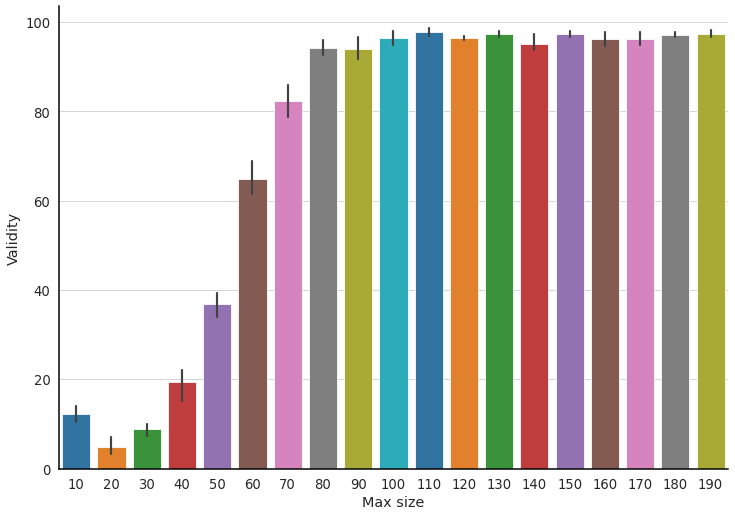

In [228]:
fig = plt.figure(figsize=(12,8.5))
sns.set_context('paper',font_scale=1.5)
sns.set_style('whitegrid')
ax=sns.barplot(x='variable',y='value',data=sizes_df,palette='tab10')
sns.despine(right=True,top=True)
ax.set_ylabel('Validity')
ax.set_xlabel('Max size')
for _,s in ax.spines.items():
    s.set_linewidth(1.5)
    s.set_color('black')

In [192]:
len(valid_smiles_normal)

98